In [32]:
using  Plots, LaTeXStrings, Printf
include("Master_func.jl")

IBP_ft (generic function with 1 method)

# Solving non-homogenous dirichlet boundary conditions
## Left boundary is one.
Say we want to solve general case
$$
\begin{cases}
\partial_t u + \omega(\partial_x)u=0,\\
u(x,0) = 0,\\
u(0,t) = 1,~u(L,t) = 0.
\end{cases}
$$
We change the function $u = \left(1-\frac{x}{L}\right) - v$, we then get
$$
\begin{cases}
\partial_t v + \omega(\partial_x)v=0,\\
v(x,0) = -(1-\frac{x}{L}),\\
v(0,t) = 0,~v(L,t) = 0.
\end{cases}
$$
We can use change of variables to find that
$$
v = XT,~~~ T_j = e^{\omega(\lambda_j)t}\text{ and }X_j = \sum_l c_{jl}e^{\alpha_l(\lambda_j)x},
$$
<span style="color:red;">Easy to show how to get the $X$, is this the only solution?</span>
where $\alpha_l \in \{\alpha|\omega(\alpha(\lambda)) = \omega(\lambda)\}$. We Should find possible $\lambda_j$ through the boundary conditions, and $c_{jl}$, through the fact that
$$
\sum_{j=1}^\infty X_j = -(1-\frac{x}{L}).
$$
We can find it for the heat equations $\omega=-\lambda^2$. We get the similarities $\alpha_1 = i\lambda$ and $\alpha_1 = -i\lambda$. Simplifying a tiny bit and finding that the boundary conditions are fulfilled if $c_{j1}=-c_{j2}$ and $\lambda_j = \frac{j\pi}{L}$. We then have that
$$
T_j = e^{-\lambda_j^2t}\text{ and }X_j = 2c_j\sin(\lambda_jx).
$$
Through projectiong, we get that $c_j = \frac{1}{\pi j}$. The solution to the original problem is then
$$ u(x,t) = 1-\frac{x}{L} - \frac{2}{\pi}\sum_{j=1}^{\infty} \frac{e^{-\left(\frac{j\pi}{L}\right)^2t}\sin(\frac{j\pi}{L}x)}{j} $$
## Right boundary is one.
We want to solve general case
$$
\begin{cases}
\partial_t u + \omega(\partial_x)u=0,\\
u(x,0) = 0,\\
u(0,t) = 0,~u(L,t) = 1,
\end{cases}
$$
through change of variables $\tilde{x}=L-x$ and then solve 
$$
\begin{cases}
\partial_t u + \tilde{\omega}(\partial_{x})u=0,\\
u(x,0) = 0,\\
u(0,t) = 1,~u(L,t) = 0,
\end{cases}
$$
where $\tilde{\omega}$ is just $\omega$ with some signs switched. 

In the heat equation case, Since $\tilde{\omega}=\omega$, we have get the PDE like the one above and voila, we just get the solution, but with a change in variables: $u(L-x,t)$.
## Left boundary is $\frac{t^n}{n!}$.
We want to solve general case
$$
\begin{cases}
\partial_t u + \omega(\partial_x)u=0,\\
u(x,0) = 0,\\
u(0,t) = \frac{t^n}{n!},~u(L,t) = 0,
\end{cases}
$$
Assuming the solution is smooth enough (nonlinear pde's might not be), we can derive it with respect to time $n$ and incorporate a change of function (ansatz?) $ v = \partial_{t^n}u$:
$$
\begin{cases}
\partial_t v + \omega(\partial_x)v=0,\\
v(x,0) = 0,\\
v(0,t) = 1,~v(L,t) = 0.
\end{cases}
$$
<span style="color:red;">Can I derive the initial condition wtr to t?</span>
This is the same problem as before, so we can integrate out previous PDE wtr time et voila. Define function
$$
V_n(x,t) =  \sum_{j=1}^{\infty} \omega(\lambda_j)^{-n}e^{\omega(\lambda_j)t}\sum_l c_{jl}e^{\alpha_l(\lambda_j)x}.
$$
We then have that 
$$u = \left(1-\frac{x}{L}\right)\frac{t^n}{n!} - V_n(x,t) + \sum_{l=1}^{n}V_l(x,0)\frac{t^{n-l}}{(n-l)!}.$$
It's easy to get the solution to this using the same coefficients and symmetries from the first PDE, we get the solution.
## General PDE
Say we want to solve general case
$$
\begin{cases}
\partial_t u + \omega(\partial_x)u=0,\\
u(x,0) = u_0(x),\\
u(0,t) = f_L(t),~u(L,t) = f_R(t).
\end{cases}
$$
We can split this problem up into the problem with the initial condition, left boundary condition or right boundary condition seperately with the rest being zero. The problem with the initial condition can be solved using UTM, the dirichlet boundary conditions can be solved by projecting $f_L$ and $f_R$ onto polynomial spaces and then using the previous PDEs and the coefficients of the projection. Summing these solutions gives us the soltuion to the general PDE.

In [53]:
function sum_s(x,t,L,n)
    sum_part = j -> sp((-1)^(n) * (L/π) ^(2*n) * exp(-(π*j/L)^2*t)*sin(π*j/L*x) / (j^(2*n+1)))
    j = 1
    res = 0
    old_res = 0
    while abs(sum_part(j)) >= 10^(-25) && !isinf(res) && j <= 10^(5)
        old_res = res
        res += sum_part(j)
        j += 1
    end
    return old_res
end

function diff_bd_solver(x,t,l,L)

    S = n -> 2/π*sum_s(x,t,L,n)
    S0 = n -> 2/π*sum_s(x,0,L,n)
    res = (l == 0 ? (1 - x/L) * t^(l) / (factorial(l)) - S(l) : (1 - x/L) * t^(l) / (factorial(l)) - S(l) + sum(map(k -> S0(k)*t^(l-k)/factorial(l-k),1:l)))
end

function coeff_calc(g,tspan,N)

    t = (tspan[2]+tspan[1])/2 .+ cos.((2 .* (0:N-1) .+ 1) ./ (2*N)*pi) .* (tspan[2]-tspan[1])/2;
    G = g.(t);
    
    A = zeros(N,N);
    for i1 = 0:(N-1)
        A[:,i1+1] = t .^ i1
    end

    return A\G
end

function dir_boundary_cond(g,x,L,tspan)
    
    N = 5

    interp_coeff = coeff_calc(g,tspan,N) .* factorial.(0:N-1)
    t = tspan[end]
    res = x .* 0
    for i1 = 1:N
        res = res .+ map(x->diff_bd_solver(x,t,i1-1,L),x) .* interp_coeff[i1]
    end
    return res
end


dir_boundary_cond (generic function with 1 method)

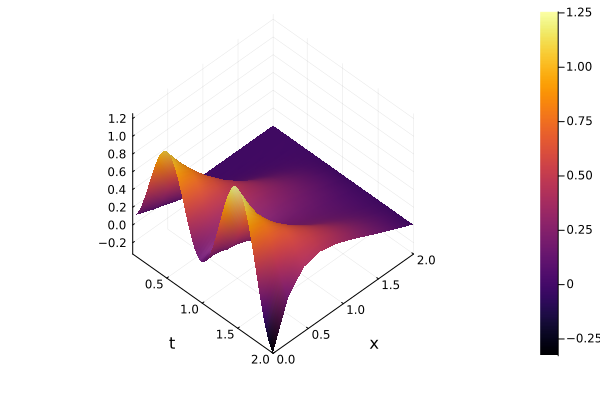

In [54]:
L = 2; 
g = t -> sin(π*t).^2+.1
SSS = (x,t) -> dir_boundary_cond(g,x,L,[0,t])

Nt = 100;
Nx = 10;
T = 2
tt = T/(Nt):T/(Nt):T
xx = 0:L/(Nx-1):L

SS = zeros(Nx,Nt)

for i2 = 1:Nt
    for i1 = 1:Nx
        SS[i1,i2] = SSS(xx[i1],tt[i2])
    end
end
surface(tt,xx, SS, camera = (45, 45), xlabel = "t", ylabel = "x")

In [50]:
plot(0:0.01:2,g.(0:0.01:2));

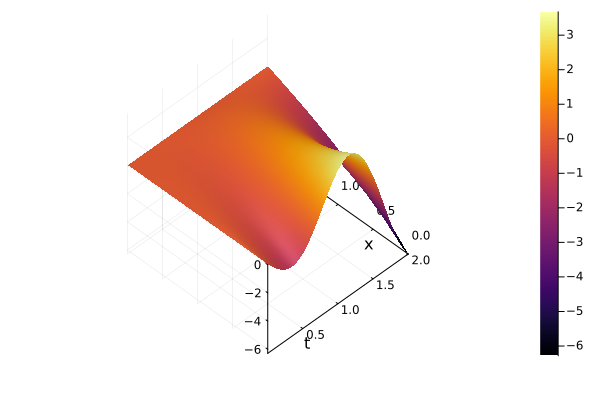

In [7]:
surface(tt,xx, SS, camera = (-45, 45), xlabel = "t", ylabel = "x")

In [34]:
t = 1; L = 2; g = x -> x
AA = x -> dir_boundary_cond(g,x,t,L)
x = 0:0.01:L 

plot(x,abs.(map(AA,x)) .+10^(-16))
plot!(x,abs.(map(AA,L .- x)) .+10^(-16))

LoadError: MethodError: no method matching Diff(::var"#745#746")

[0mClosest candidates are:
[0m  Diff(::Any, [91m::Any[39m)
[0m[90m   @[39m [35mMain[39m [90mc:\Users\wiets\OneDrive\Documenten\GitHub\Tom-reading-course\Memos\[39m[90m[4mCheb.jl:102[24m[39m
[0m  Diff([91m::UltraFun[39m)
[0m[90m   @[39m [35mMain[39m [90mc:\Users\wiets\OneDrive\Documenten\GitHub\Tom-reading-course\Memos\[39m[90m[4mCheb.jl:106[24m[39m


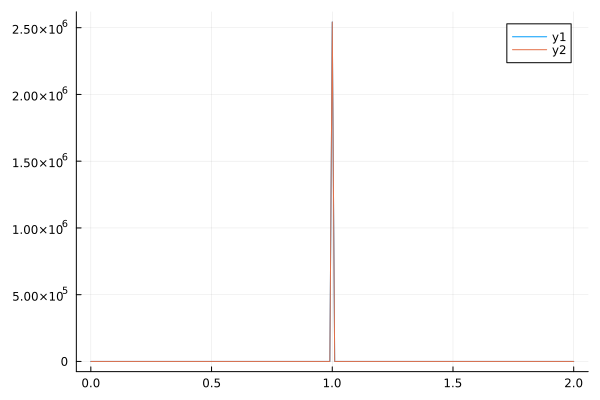

In [15]:
t = 1; L = 2; g = x -> x
AA = x -> dir_boundary_cond(g,x,t,L)
x = 0:0.01:L 

plot(x,abs.(map(AA,x)) .+10^(-16))
plot!(x,abs.(map(AA,L .- x)) .+10^(-16))

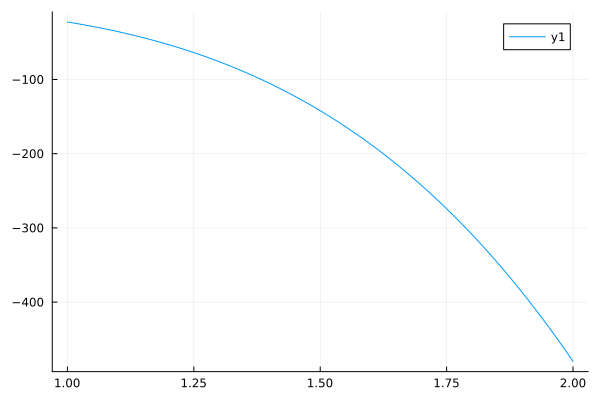

In [37]:
t = 1; N = 5;
cc = coeff_calc(g,t,L,N)
t = 1:0.001:2

plot(t,cc[1] .+ cc[2] .* t ./ factorial(1) + cc[3] .* t.^2 ./ factorial(2) + cc[4] .* t.^3 ./ factorial(3) + cc[5] .* t.^4 ./ factorial(4) )